In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import os 
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Model 

In [2]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\86183\tensorflow_datasets\fashion_mnist\3.0.1.incomplete84XMVT\fashion_mnist-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\86183\tensorflow_datasets\fashion_mnist\3.0.1.incomplete84XMVT\fashion_mnist-test.tfrecord*…

Dataset fashion_mnist downloaded and prepared to C:\Users\86183\tensorflow_datasets\fashion_mnist\3.0.1. Subsequent calls will reuse this data.


In [3]:
ds.as_numpy_iterator().next()['label']

2

In [4]:
import numpy as np

In [5]:
dataiterator = ds.as_numpy_iterator()

In [6]:
dataiterator.next()['image'].shape

(28, 28, 1)

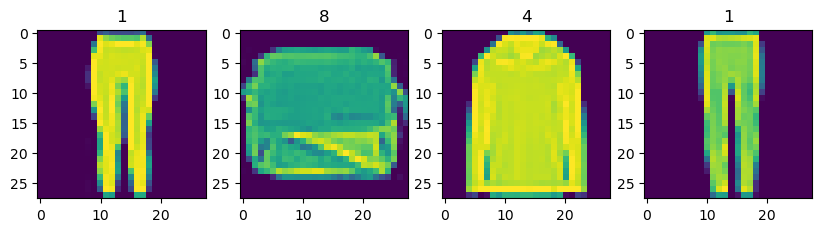

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(10, 10))

for idx in range(4):
    batch = dataiterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [8]:
def scale_images(data):
    image = data['image']
    return image / 255

In [9]:
ds = tfds.load('fashion_mnist', split='train')  # 这几行代码必须一起写

ds = ds.map(scale_images)
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [10]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## Build Net

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [12]:
def build_generator():
    model = Sequential()

    model.add(Dense(7 * 7 * 128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7, 128)))

    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [13]:
generator = build_generator()

In [14]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [15]:
img = generator.predict(np.random.randn(4, 128, 1))
img

1/1 [==============================] - 0s 188ms/step


array([[[[0.50825006],
         [0.50796103],
         [0.50071824],
         ...,
         [0.4978448 ],
         [0.50146973],
         [0.50309324]],

        [[0.5089822 ],
         [0.5101024 ],
         [0.50623804],
         ...,
         [0.5006382 ],
         [0.5011899 ],
         [0.50245535]],

        [[0.5114626 ],
         [0.5108667 ],
         [0.5078093 ],
         ...,
         [0.50315595],
         [0.4980485 ],
         [0.4993491 ]],

        ...,

        [[0.49975145],
         [0.5035564 ],
         [0.5064885 ],
         ...,
         [0.51003575],
         [0.50589156],
         [0.5011975 ]],

        [[0.50015   ],
         [0.49978307],
         [0.50212675],
         ...,
         [0.5043078 ],
         [0.5038341 ],
         [0.50151914]],

        [[0.50017834],
         [0.49948525],
         [0.50053895],
         ...,
         [0.5033673 ],
         [0.5027234 ],
         [0.5021109 ]]],


       [[[0.5052782 ],
         [0.5118596 ],
         [0.50

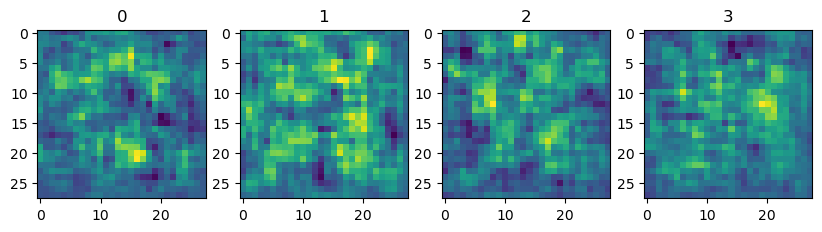

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(10, 10))

for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

In [17]:
def build_discriminator():
    model = Sequential()
    
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [18]:
discriminator = build_discriminator()

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [20]:
discriminator.predict(np.expand_dims(img, 0))

1/1 [==============================] - 0s 68ms/step


array([[0.4954555]], dtype=float32)

## Construct Training Loop

In [21]:
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import BinaryCrossentropy

In [22]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [23]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
        
    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
        
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)
            
            predicted_labels = self.discriminator(gen_images, training=False)
            
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
            
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss": total_d_loss, "g_loss": total_g_loss}
    

In [24]:
fashgan = FashionGAN(generator, discriminator)

In [25]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [26]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [27]:
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
  1/469 [..............................] - ETA: 1:11:34 - d_loss: 0.6920 - g_loss: 0.6846

KeyboardInterrupt: 

In [ ]:
plt.suptitle('Loss')
x_ticks=np.arange(1,21)
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

## Test Generator

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10, 10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r + 1) * (c + 1)-1]) 